### Real-Data Benchmarking

This notebook goes over a collection of estimators used to model trend (change in mean) across a time series. Specifically a focus is on trend filtering and it's performance in estimation and computation time against splines, kernels, and segmented regression

In [1]:
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
sys.path.append("../")


PATH = "../../../../taq_db/TAQ-Query-Scripts/data/features/2020-01-02/"
sys.path.append(PATH)

os.listdir(PATH)[:20]

['CNC_reconstructed_features.csv',
 'ABBV_reconstructed_features.csv',
 'BWA_reconstructed_features.csv',
 'GOOG_reconstructed_features.csv',
 'AVGO_reconstructed_features.csv',
 'AME_reconstructed_features.csv',
 'CPT_reconstructed_features.csv',
 'BAX_reconstructed_features.csv',
 'BDX_reconstructed_features.csv',
 'AFL_reconstructed_features.csv',
 'CNP_reconstructed_features.csv',
 'CE_reconstructed_features.csv',
 'ANET_reconstructed_features.csv',
 'APD_reconstructed_features.csv',
 'ADBE_reconstructed_features.csv',
 'BAC_reconstructed_features.csv',
 'AES_reconstructed_features.csv',
 'CHTR_reconstructed_features.csv',
 'ADM_reconstructed_features.csv',
 'CDAY_reconstructed_features.csv']

In [2]:
os.listdir(PATH)

DATA_FILE = "AMZN_reconstructed_features.csv"

In [3]:
market_data = pd.read_csv(PATH + DATA_FILE, index_col=0,nrows=10000)
market_data.index = pd.to_datetime(market_data.index)

trade_data= market_data[market_data["Trade_Volume"] > 0]


### Screening by sale condtion of trades

- Examining only regular trades allows for a much better performace in terms of efficiency and estimation



In [4]:
regular_trades = trade_data[trade_data["Sale_Condition"] == "@   "]
regular_trades["Log_Return"] = np.log(regular_trades["Trade_Price"]) - np.log(regular_trades["Trade_Price"].shift(1))
regular_trades.head()


/tmp/ipykernel_118107/2314521291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_trades["Log_Return"] = np.log(regular_trades["Trade_Price"]) - np.log(regular_trades["Trade_Price"].shift(1))


,Date,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,Trade_Correction_Indicator,Sequence_Number,Trade_Id,...,Imbalance,MOX_Identifier,Effective_Spread,Microprice,Imbalance_Weighted_Effective_Spread,Price_Impact,Realized_Spread,Midprice,Trade_Side,Log_Return
index,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:00.820,2020-01-02,D,AMZN,100.0,1874.5450,@,N,0.0,21402,140.0,...,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24389,191.0,...,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000105
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24286,185.0,...,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2020-01-02 09:30:01.040,2020-01-02,D,AMZN,100.0,1874.7400,@,N,0.0,24778,233.0,...,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000001
2020-01-02 09:30:01.160,2020-01-02,D,AMZN,200.0,1874.9900,@,N,0.0,26914,252.0,...,NaN,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000133


In [5]:

print("Number of trades: ", len(regular_trades))

Number of trades:  540


In [6]:
trade_data["Sale_Condition"].unique()

array(['@  I', '@F I', '@  Q', '@ TI', '@O X', '@   ', '@F  ', '@4 I',
       '@4 W', '@ ZI', 'R  W'], dtype=object)

### Visualizing Market Data

Plotted below is AMZN trade price and volume data 

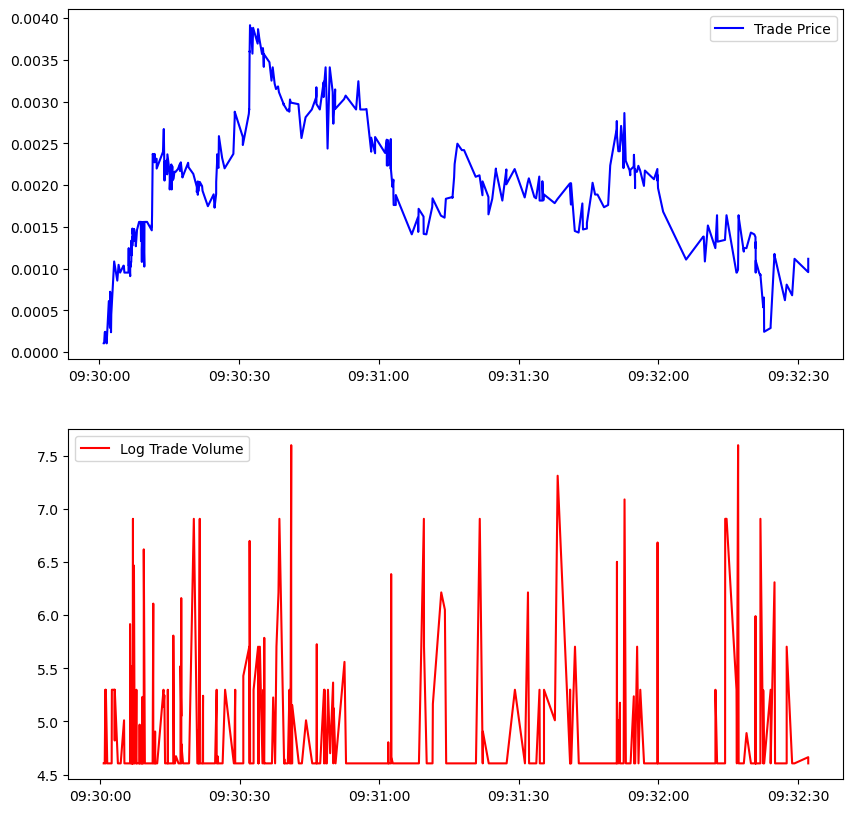

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

log_trade_return = np.cumsum(regular_trades["Log_Return"].dropna())
trade_volume=regular_trades["Trade_Volume"]


ax[0].plot(log_trade_return, label="Trade Price",color='blue')

ax[1].plot(np.log(trade_volume), label="Log Trade Volume",color='red')

ax[0].legend()
ax[1].legend()

plt.show()



### Quick Performance of Trend Filtering

In [8]:
import sys
sys.path.append("../../")
from estimators.trend_filtering.trend_filter import Trend_Filter

from estimators.cv_base_estimator import cv_base_estimator

In [29]:
x=np.arange(1,len(regular_trades))


tf= Trend_Filter(x=x, y=log_trade_return.values, k=1, method="primal_dual")

start = time.time()
cv_base_estimator(tf)

print("Time taken: ", time.time() - start)

Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 0.0009234271582654394
Performing cross validation for lambda = 0.0017828587172521969
Performing cross validation for lambda = 0.00344216127631852
Performing cross validation for lambda = 0.006645772958638042
Performing cross validation for lambda = 0.012830978757916181
Performing cross validation for lambda = 0.02477274154725799
Performing cross validation for lambda = 0.04782867584350277
Performing cross validation for lambda = 0.09234271582654394
Performing cross validation for lambda = 0.17828587172521967
Performing cross validation for lambda = 0.34421612763185205
Performing cross validation for lambda = 0.6645772958638034
Performing cross validation for lambda = 1.283097875791618
Performing cross validation for lambda = 2.4772741547257993
Performing cross validation for lambda = 4.782867584350272
Performing cross validation for lambda = 9.234271582654394
Performing  1 out of 3 iterations

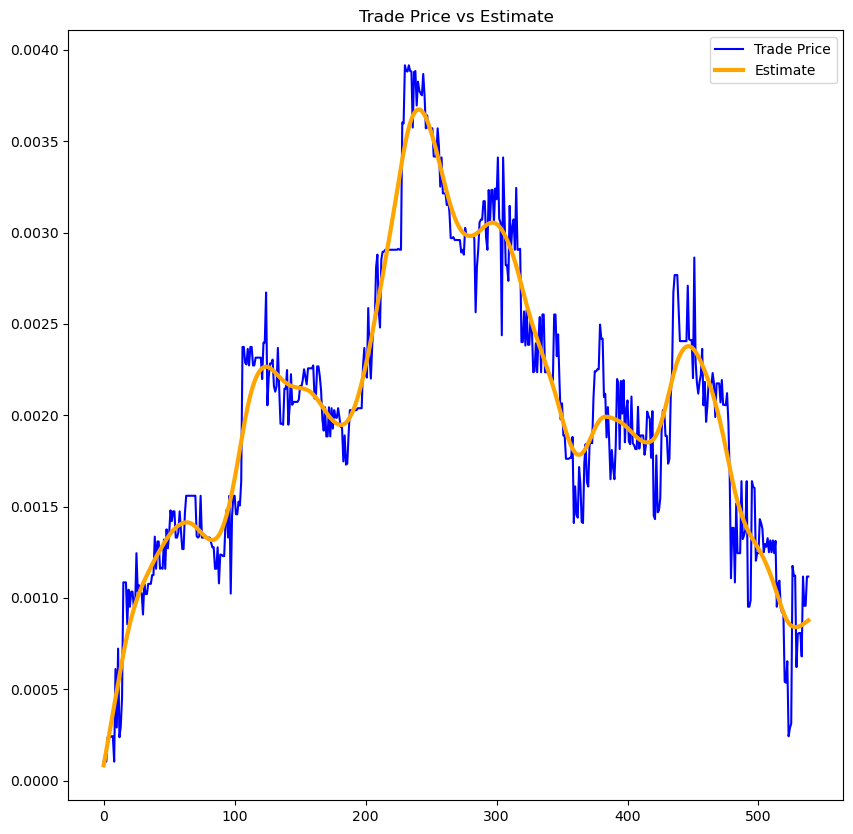

In [30]:


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(log_trade_return.values, label="Trade Price",color='blue')

ax.plot(tf.y_hat, label="Estimate",lw=3,color='orange')

ax.legend()

ax.set_title("Trade Price vs Estimate")

plt.show()

### Inference via ADMM

In [11]:
admm_tf= Trend_Filter(x=x, y=log_trade_return.values, k=1, method="admm")

start = time.time()

cv_base_estimator(admm_tf)

print("Time taken: ", time.time() - start)


Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 0.000954475482676401
Performing cross validation for lambda = 0.0018428036466780707
Performing cross validation for lambda = 0.0035578968154191216
Performing cross validation for lambda = 0.0068692233011306515
Performing cross validation for lambda = 0.013262393826684846
Performing cross validation for lambda = 0.025605673640735665
Performing cross validation for lambda = 0.04943681594469409
Performing cross validation for lambda = 0.0954475482676401
Performing cross validation for lambda = 0.18428036466780706
Performing cross validation for lambda = 0.35578968154191215
Performing cross validation for lambda = 0.6869223301130645
Performing cross validation for lambda = 1.3262393826684846
Performing cross validation for lambda = 2.5605673640735667
Performing cross validation for lambda = 4.943681594469403
Performing cross validation for lambda = 9.54475482676401
Performing  1 out of 3 iteratio

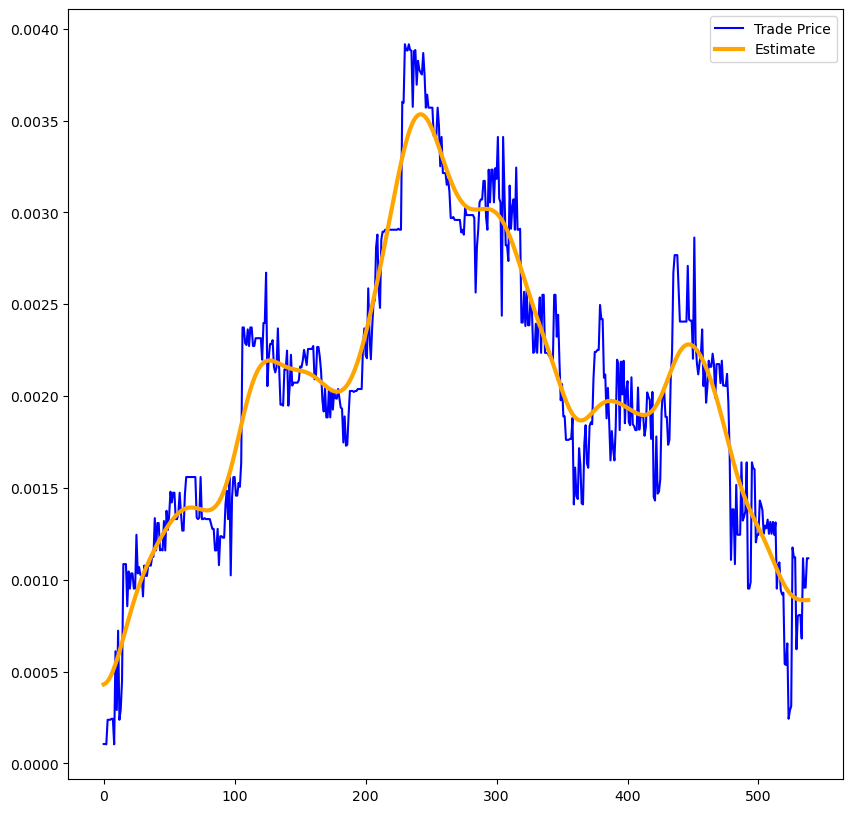

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(log_trade_return.values, label="Trade Price",color='blue')

ax.plot(admm_tf.y_hat, label="Estimate",lw=3,color='orange')

ax.legend()


### Regime Detection from Estimated Trend

In [13]:
from estimators.regression.piecewise_polynomial import Piecewise_Polynomial_Model

In [14]:
regime_model=Piecewise_Polynomial_Model(x=x, y=tf.y_hat, k=1, method="continous_tf")

[230 232 376 379 435 437 521 523]
{1: [230], 2: [230, 435], 3: [230, 376, 435], 4: [230, 376, 435, 523], 5: [230, 376, 435, 437, 523], 6: [230, 376, 379, 435, 437, 523], 7: [230, 376, 379, 435, 437, 521, 523], 8: [230, 232, 376, 379, 435, 437, 521, 523], 0: []}
k: 0 mse: 5.931094245846286e-07
k: 1 mse: 2.1127908440746928e-07
k: 2 mse: 1.807252425781148e-07
k: 3 mse: 1.695081113270315e-07
k: 4 mse: 1.6164029214775496e-07
k: 5 mse: 1.605899175329865e-07
k: 6 mse: 1.6034840923000343e-07
k: 7 mse: 1.601528728030687e-07
k: 8 mse: 1.6012167246241152e-07


In [15]:
regime_model.all_models

{0: 0.356222773825309,
 1: 0.8553863392817964,
 2: 0.9379326811735503,
 3: 0.9535844089248497,
 4: 0.9935017773055724,
 5: 0.9984961178964833,
 6: 0.9987805527483953,
 7: 0.9998051840088091}

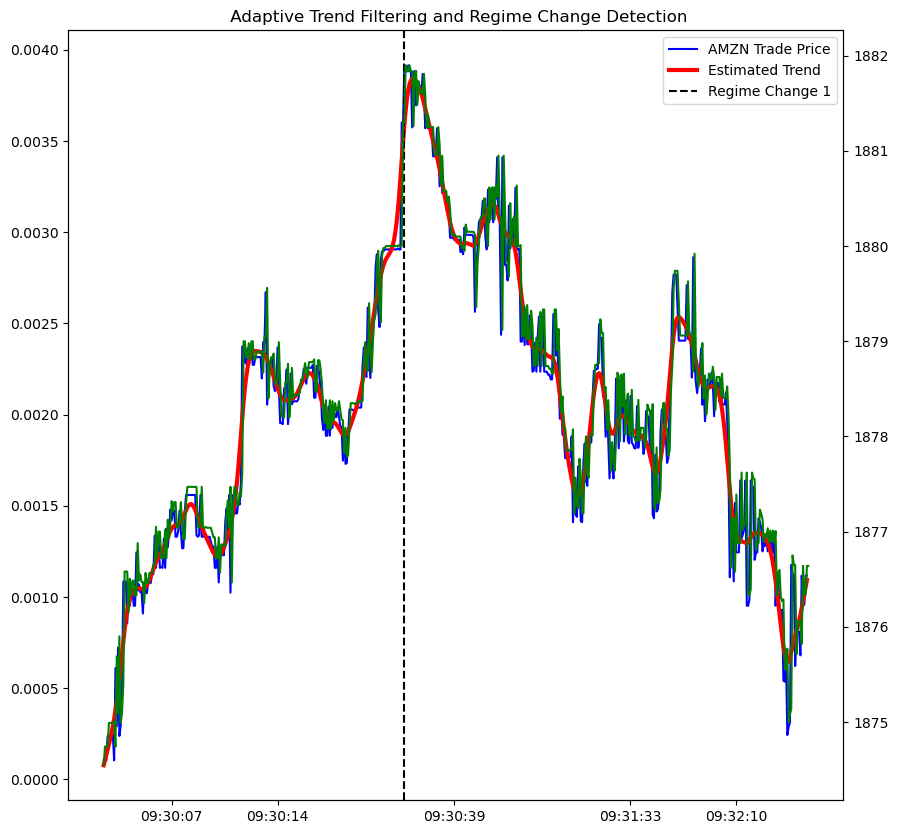

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(log_trade_return.values, label="AMZN Trade Price",color='blue')
ax.plot(tf.y_hat, label="Estimated Trend ",color='red',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(regime_model.knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(log_trade_return.values)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

ax2=ax.twinx()
trade_price=regular_trades["Trade_Price"].values
ax2.plot(trade_price, label="Trade Price",color='green')

### Ratio of Loss Functions (Used for Model Selection)

In [17]:
model_selection=regime_model.all_models

model_selection

{0: 0.356222773825309,
 1: 0.8553863392817964,
 2: 0.9379326811735503,
 3: 0.9535844089248497,
 4: 0.9935017773055724,
 5: 0.9984961178964833,
 6: 0.9987805527483953,
 7: 0.9998051840088091}

Text(0.5, 1.0, 'Model Selection')

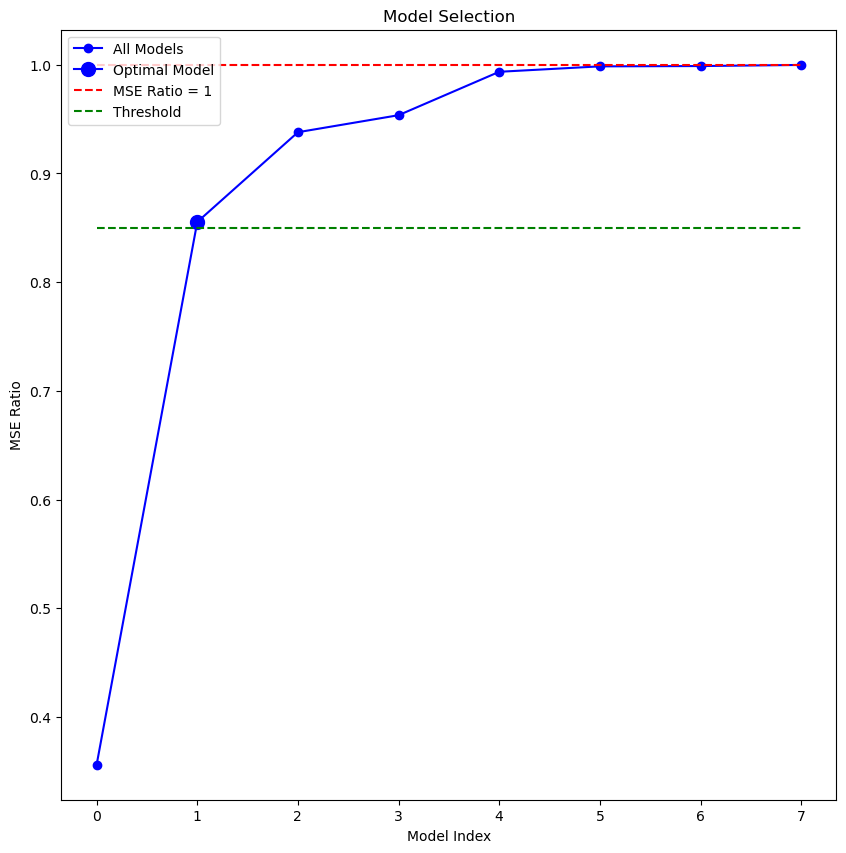

In [18]:
keys=list(model_selection.keys())
values=list(model_selection.values())
all_other_models=[(i,values[i]) for i in range(len(values)) if i !=regime_model.optimal_model]


nu=regime_model.nu

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(keys,values,label="All Models",color='blue',marker='o')
ax.plot(regime_model.optimal_model,model_selection[regime_model.optimal_model],label="Optimal Model",color='blue',marker='o',markersize=10)
ax.hlines(1,keys[0],keys[-1],color='red',linestyle='--',label="MSE Ratio = 1")
ax.hlines(1-nu,keys[0],keys[-1],color='green',linestyle='--',label="Threshold")

ax.legend()
ax.set_ylabel("MSE Ratio")
ax.set_xlabel("Model Index")
ax.set_title("Model Selection")



### Time Dependent Trend Filtering

Careful consideration to round timestamps for observations with near identical timestamps

In [19]:
regular_trades['Round_Timestamp'] = regular_trades.index.round('1ms')

round_regular_trades = regular_trades.groupby('Round_Timestamp').agg({'Trade_Price': 'mean', 'Trade_Volume': 'sum', 'Log_Return': 'sum'})

round_regular_trades.head()

/tmp/ipykernel_118107/3849918056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_trades['Round_Timestamp'] = regular_trades.index.round('1ms')


,Trade_Price,Trade_Volume,Log_Return
Round_Timestamp,,,
2020-01-02 09:30:00.820,1874.5450,100.0,0.000000
2020-01-02 09:30:00.948,1874.7425,200.0,0.000105
2020-01-02 09:30:01.040,1874.7400,100.0,-0.000001
2020-01-02 09:30:01.160,1874.9900,200.0,0.000133
2020-01-02 09:30:01.180,1874.9900,200.0,0.000000


In [20]:
time_trade_price=np.cumsum(round_regular_trades["Log_Return"].values)

timestamps=round_regular_trades.index-regular_trades.index[0]

timestamps=timestamps.total_seconds().values




In [21]:
time_tf= Trend_Filter(x=timestamps, y=time_trade_price, k=1, method="primal_dual")

start = time.time()
cv_base_estimator(time_tf)

print("Time taken: ", time.time() - start)

Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 0.00014635434482188382
Performing cross validation for lambda = 0.00028256600115980705
Performing cross validation for lambda = 0.0005455495366988611
Performing cross validation for lambda = 0.0010532912514978014
Performing cross validation for lambda = 0.002033587027119401
Performing cross validation for lambda = 0.0039262418547458666
Performing cross validation for lambda = 0.00758038623200421
Performing cross validation for lambda = 0.01463543448218838
Performing cross validation for lambda = 0.028256600115980704
Performing cross validation for lambda = 0.054554953669886115
Performing cross validation for lambda = 0.10532912514978002
Performing cross validation for lambda = 0.20335870271194006
Performing cross validation for lambda = 0.39262418547458666
Performing cross validation for lambda = 0.7580386232004201
Performing cross validation for lambda = 1.463543448218838
Performing  1 out o

In [22]:
time_regime_model=Piecewise_Polynomial_Model(x=timestamps, y=time_tf.y_hat, k=1, method="continous_tf")

[137 165 171]
{1: [165], 2: [165, 171], 3: [137, 165, 171], 0: []}
k: 0 mse: 5.414509629920176e-07
k: 1 mse: 1.332729705130923e-07
k: 2 mse: 1.354886449885043e-07
k: 3 mse: 1.4296726142495098e-07


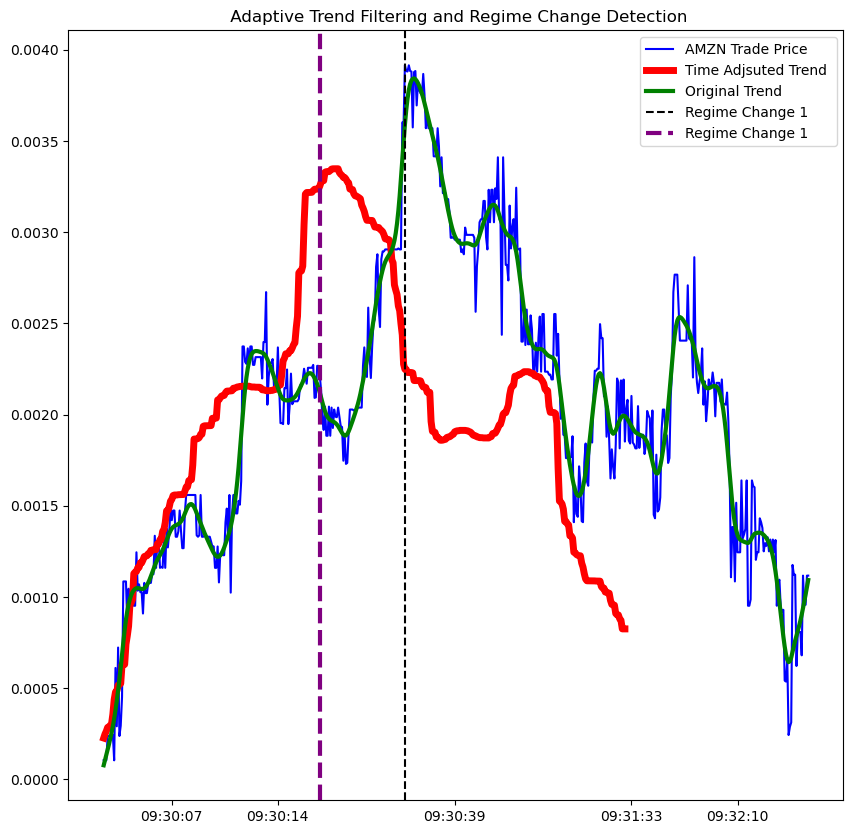

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(log_trade_return.values, label="AMZN Trade Price",color='blue')
ax.plot(time_tf.y_hat, label="Time Adjsuted Trend ",color='red',lw=5)
ax.plot(tf.y_hat, label="Original Trend",color='green',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(regime_model.knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

for i in range(len(time_regime_model.knots)):
    ax.axvline(time_regime_model.knots[i],color='purple',linestyle='--',label=f"Regime Change {i+1}",lw=3)


ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(log_trade_return.values)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

Text(0.5, 1.0, 'Model Selection')

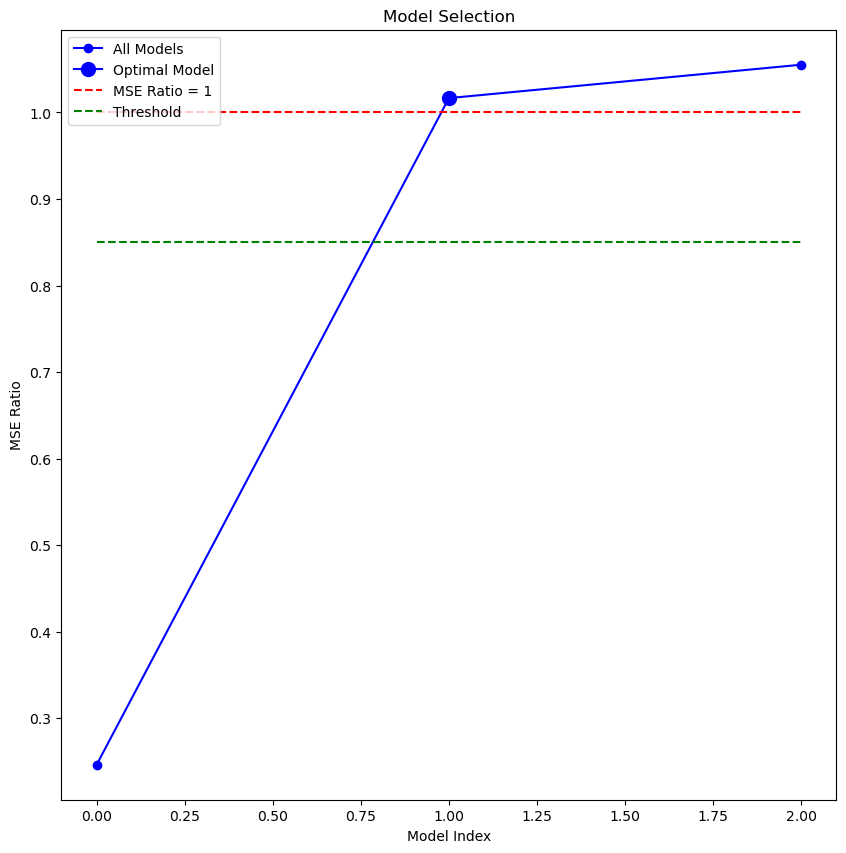

In [24]:
model_selection=time_regime_model.all_models

keys=list(model_selection.keys())
values=list(model_selection.values())
all_other_models=[(i,values[i]) for i in range(len(values)) if i != time_regime_model.optimal_model]

nu=time_regime_model.nu

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(keys,values,label="All Models",color='blue',marker='o')
ax.plot(time_regime_model.optimal_model,model_selection[time_regime_model.optimal_model],label="Optimal Model",color='blue',marker='o',markersize=10)
ax.hlines(1,keys[0],keys[-1],color='red',linestyle='--',label="MSE Ratio = 1")
ax.hlines(1-nu,keys[0],keys[-1],color='green',linestyle='--',label="Threshold")

ax.legend()
ax.set_ylabel("MSE Ratio")
ax.set_xlabel("Model Index")
ax.set_title("Model Selection")
